## Chromaticity Spaces and Illuminate Spectral Ratio  
This notebook implements various aspects of Maxwell's RoadVision Paper

___ 
### Packages

In [82]:
import cv2  
import pandas as pd  
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pathlib import Path


___
### Set Up Paths

In [83]:
HOME = Path.cwd()
PATH_TO_DATA_FOLDER = HOME / "data" / "folder_8" / "done"
PATH_TO_ANNOTATIONS_CSV =  HOME / "data" / "folder_8"
img_file =  "wenqing_fan_086.tif" #"wenqing_fan_0101.tif" # "walsh_john_035.tif" 
annotations_csv_file = "annotation_folder_8.csv"
epsilon = 1e-10 # to be used to avoid dividing by zero
anchor_point = 11.1


## Helper Functions

In [84]:
def convert_16bit_to_8bit(img):
    """
    Converts a 16-bit image to 8-bit by normalizing pixel values.

    Parameters:
    -----------
    img : np.array
        Input image array in 16-bit format (dtype: np.uint16).
    
    Returns:
    --------
    img_8bit : np.array
        Output image array converted to 8-bit (dtype: np.uint8).
    """
    img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img_8bit = np.uint8(img_normalized)

    return img_8bit

def display_image(img:np.array, title:str) -> None:
    """ 
    Displays an image (16 bit or 8 bit) in 8bit using mayplotlib

    Parameters:
    -----------
    img : np.array
        Image to plot using matplotlib. Must be in RGB colorspace.
    title : str
        Plot title.

    Returns:
    --------
    None
    """
   
    img_8bit = convert_16bit_to_8bit(img)
    plt.imshow(img_8bit)
    plt.title(title)
    plt.axis('off')
    plt.show();


___ 
### Read In Test Image

In [85]:
img_16bit = cv2.imread(str(PATH_TO_DATA_FOLDER) + "/" + img_file, cv2.IMREAD_UNCHANGED)
img_16bit = cv2.cvtColor(img_16bit, cv2.COLOR_BGR2RGB)
img_16bit.dtype

dtype('uint16')

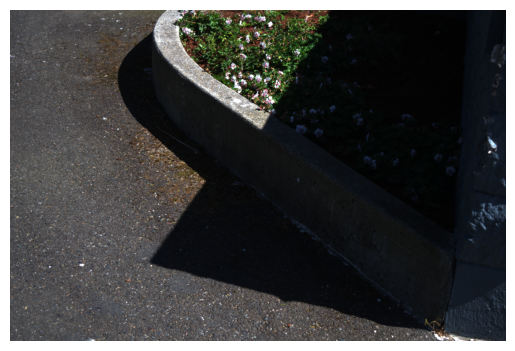

In [86]:
img_normalized = cv2.normalize(img_16bit, None, 0, 255, cv2.NORM_MINMAX)
img_8bit = np.uint8(img_normalized)
plt.imshow(img_8bit)
plt.axis("off");

___
### Convert ```img``` to Standard Chromaticity Space

$$ (\hat{r}, \hat{g}) = \bigg(\frac{R}{(R + G + B)}, \frac{G}{(R + G + B)}\bigg) $$

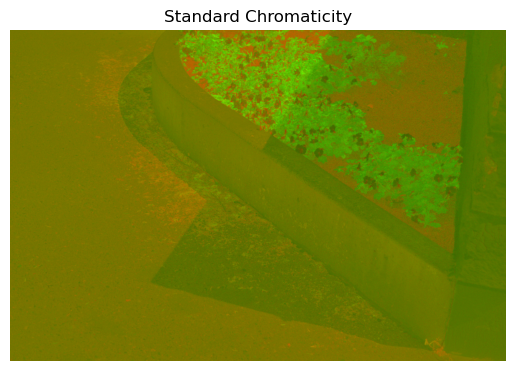

In [87]:
def convert_img_to_rg_chromaticity(img: np.array, epsilon: float = 1e-10, rg_only=False) -> np.array:
    """  
    Generates the rg chromaticity image from an RGB image.

    Parameters:
    -----------
    img : np.array
        Input RGB image as a 3D NumPy array with shape (H, W, 3).
    epsilon : float, optional (default=1e-10)
        A small value added to avoid division by zero.

    Returns:
    --------
    chromaticity_image : np.array
        Chromaticity image as a 3D NumPy array with shape (H, W, 3).
        The third (blue) channel is filled with zeros for visualization.
    
    Explanation:
    ------------
    This function converts an RGB image into rg chromaticity space, 
    where the r and g channels represent the proportion of red and green 
    in each pixel relative to the total pixel intensity. The blue channel is 
    set to zero to highlight the r and g components.
    """

    # Ensure floating-point precision
    img = img.astype(np.float32)
    
    # Compute the sum across channels
    rgb_sum = img.sum(axis=2, keepdims=True) + epsilon  # Avoid division by zero
    
    # Normalize to chromaticity space
    chromaticity = img / (rgb_sum + epsilon)
    
    if rg_only:
        # Extract the r and g channels
        r_channel = chromaticity[:, :, 0]
        g_channel = chromaticity[:, :, 1]

        # Add a blue channel of zeros for visualization
        chromaticity = np.stack((r_channel, g_channel, np.zeros_like(r_channel)), axis=2)

    # Ensure values are clipped and scaled properly
    chromaticity = np.clip(chromaticity, 0, 1)

    # Convert to a displayable range [0, 255]
    chromaticity_img = (chromaticity * 255).astype(np.uint8)

    return chromaticity_img



chromaticity_image = convert_img_to_rg_chromaticity(img_16bit, rg_only=True)
display_image(chromaticity_image, "Standard Chromaticity")

___
### Estimate Illuminate Spectral Direction  
This requires lit and shadow pixels

___ 
### Read In CSV of Lit & Shadowed Pixels

In [88]:
annotations_df = pd.read_csv(str(PATH_TO_ANNOTATIONS_CSV) + "/" + annotations_csv_file, index_col = "filename")
annotations_df.head()


,lit_row1,lit_col1,shad_row1,shad_col1,lit_row2,lit_col2,shad_row2,shad_col2,lit_row3,lit_col3,...,shad_row4,shad_col4,lit_row5,lit_col5,shad_row5,shad_col5,lit_row6,lit_col6,shad_row6,shad_col6
filename,,,,,,,,,,,,,,,,,,,,,
walsh_john_001.tif,682,395,649,485,693,433,664,513,737,461,...,683,709,732,710,688,759,702,338,659,429
walsh_john_015.tif,788,317,764,385,291,166,282,230,348,168,...,695,330,898,413,879,451,446,814,438,881
wenqing_fan_010.tif,670,156,684,235,709,142,745,195,754,112,...,741,668,650,580,650,675,477,635,481,748
wenqing_fan_004.tif,927,861,802,789,920,998,808,838,363,916,...,395,959,365,1036,407,1004,155,894,221,606
wenqing_fan_038.tif,692,400,599,404,708,463,570,465,724,537,...,557,648,741,346,765,191,689,611,635,619


### Get Pixel Coordinates  
This will extract the lit and shadow pixel coordinates from the annotations csv

In [89]:
def get_lit_shadow_pixel_coordinates(annotations_df:pd.DataFrame, image_file_name:str) -> tuple:
    """  
    Extracts the lit and shadow pixel locations from the annoations df.
    Note: filename has to be set as the index for annotation df
    """
    # Extract annotations for image of interest
    image_annotations = annotations_df.loc[image_file_name]

    # Extract lit and shadow pixels
    lit_pixels = [
        (image_annotations[f"lit_row{i}"], image_annotations[f"lit_col{i}"])
        for i in range(1, 7)
    ]
    shadow_pixels = [
        (image_annotations[f"shad_row{i}"], image_annotations[f"shad_col{i}"])
        for i in range(1, 7)
    ]
    return lit_pixels, shadow_pixels

lit_pixels, shadow_pixels = get_lit_shadow_pixel_coordinates(annotations_df, img_file)

print(f"Lit pixels: {lit_pixels}")
print(f"Shadow Pixels: {shadow_pixels}")


Lit pixels: [(309, 735), (281, 692), (862, 532), (882, 574), (839, 484), (904, 675)]
Shadow Pixels: [(377, 821), (411, 875), (764, 582), (792, 629), (759, 536), (811, 693)]


### Inspect the Annotations

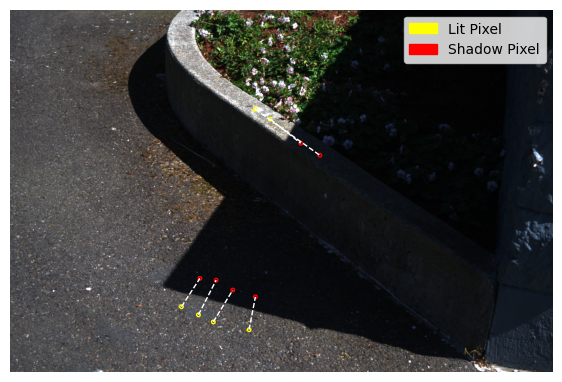

In [90]:
def inspect_annotations(img:np.array, lit_pixels:list, shadow_pixels:list) -> None:
    """  
    Displays the image with lit and shadow pixels highlighted
    """
    fig, ax = plt.subplots(figsize = (7, 12))
    
    img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img_8bit = np.uint8(img_normalized)
    ax.imshow(img_8bit)

    # Add circles around lit pixels
    for (y, x) in lit_pixels:
        circle = patches.Circle((x, y), radius=5, edgecolor='yellow', facecolor='none', linewidth=1, label='Lit Pixel')
        ax.add_patch(circle)

    # Add circles arond the shadow pixels
    for (y, x) in shadow_pixels:
        circle = patches.Circle((x, y), radius=5, edgecolor='red', facecolor='none', linewidth=1, label='Shadow Pixel')
        ax.add_patch(circle)

    # Draw lines between lit and shadow pixel pairs
    for (y1, x1), (y2, x2) in zip(lit_pixels, shadow_pixels):
        ax.plot([x1, x2], [y1, y2], linestyle='--', color='white', linewidth=1)

    # Add the legend
    handles = [
        patches.Patch(color='yellow', label='Lit Pixel'),
        patches.Patch(color='red', label='Shadow Pixel')
    ]
    plt.legend(handles = handles)
    plt.axis('off')
    plt.show()

inspect_annotations(img_8bit, lit_pixels, shadow_pixels)


In [91]:
print(lit_pixels)
print(shadow_pixels)

[(309, 735), (281, 692), (862, 532), (882, 574), (839, 484), (904, 675)]
[(377, 821), (411, 875), (764, 582), (792, 629), (759, 536), (811, 693)]


### Convert Image to log space
___

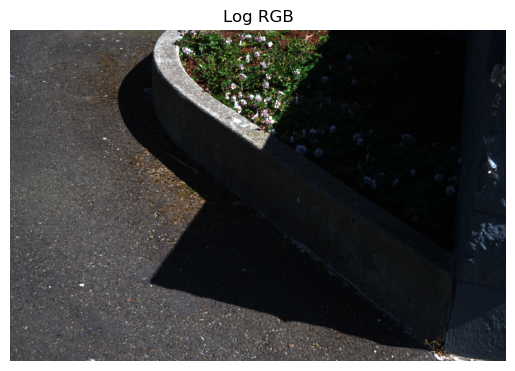

In [92]:
def convert_img_to_log_space(img: np.array, epsilon=1e-10, norming=False) -> np.array:
    """
    Converts a 16-bit linear image to log space, setting linear 0 values to 0 in log space.

    Parameters:
    -----------
    img : np.array
        Input 16-bit image as a NumPy array.

    Returns:
    --------
    log_img : np.array
        Log-transformed image with 0 values preserved.
    """

    # Prepare a mask to keep zero-valued pixels unchanged
    zero_mask = (img == 0)

    # Apply the log transformation
    log_img = np.log(img + epsilon)  

    # Set log-transformed values to 0 where the original pixels were 0
    log_img[zero_mask] = 0

    if norming:
        log_img = (log_img - log_img.min()) / (log_img.max() - log_img.min()) * 11.1

    assert np.min(log_img) >= 0 and np.max(log_img) <= 11.1


    return log_img

def log_to_linear(log_rgb: np.array) -> np.array:
    """
    COnverts log transofrmed image back to linear space in 16 bits.

    Parameters:
    -----------
    log_rgb : np.array
        Log-transformed image with values between 0 and 11.1.

    Returns:
    --------
    vis_img : np.array
        Visualization-ready 8-bit image.
    """

    linear_img = np.exp(log_rgb)


    return linear_img


log_rgb = convert_img_to_log_space(img_16bit)
log_rgb_linear = log_to_linear(log_rgb)
display_image(log_rgb_linear, "Log RGB")


### Compute the ISD  
This is from 4.1 of Lightbrush:  

4.1 Base Constraints and Linear System Representation
4.1.1 Illumination Spectral Direction. The only required user input
is an estimate of the illumination spectral direction. The ISD
defines the log chromaticity space for the log-chromaticity clustering
step. While automated schemes for detecting the ISD are
possible, we opt to allow simple user control. Lightbrush includes a
lit-dark pair tool that consists of two linked squares (Figure 4(a)).
The user places one square in a lit area of a material and the other
square in a shadowed area of the same material. The system uses
the average value under each block to estimate the ISD. If the user
specifies multiple lit-dark pairs, they can tell Lightbrush to average
the estimated ISDs or use a local adaptation scheme to deal with
changing illumination conditions within the scene.

In [93]:
def compute_isd(log_rgb: np.array, lit_pixels: list, shadow_pixels: list) -> np.array:
    """
    Computes the Illumination Subspace Direction (ISD) vector 
    by comparing pixel values between lit and shadow regions in log RGB space.

    Parameters:
    -----------
    log_rgb : np.array
        The log-transformed image.
    lit_pixels : list of tuples
        List of (x, y) coordinates representing pixels in the lit region.
    shadow_pixels : list of tuples
        List of (x, y) coordinates representing pixels in the shadow region.

    Returns:
    --------
    isd : np.array
        A 3-element vector representing the unit-normalized ISD vector.
        This vector shows how RGB values shift due to illumination changes.
    """

    def get_patch_mean(img, x_coords, y_coords, filter_size=3):
        """
        Extracts and computes the mean of 3x3 patches centered on the given coordinates.
        """
        half_filter = filter_size // 2
        means = []
        
        for x, y in zip(x_coords, y_coords):
            # Ensure patch bounds stay within the image
            x_min = max(0, x - half_filter)
            x_max = min(img.shape[1], x + half_filter + 1)
            y_min = max(0, y - half_filter)
            y_max = min(img.shape[0], y + half_filter + 1)

            # Extract the patch and compute mean
            patch = img[y_min:y_max, x_min:x_max]
            patch_mean = np.mean(patch, axis=(0, 1))  # Mean over height, width, and channels
            means.append(patch_mean)

        return np.mean(means, axis=0)  # Mean across all patches

    # Compute means of patches for lit and shadow regions
    lit_means = get_patch_mean(log_rgb, *zip(*lit_pixels))
    shadow_means = get_patch_mean(log_rgb, *zip(*shadow_pixels))

    # Calculate the pixel difference between lit and shadow means
    pixel_diff = lit_means - shadow_means

    # Normalize the difference to get the ISD vector
    isd = pixel_diff / np.linalg.norm(pixel_diff)

    return isd

# Example usage
isd = compute_isd(log_rgb, lit_pixels, shadow_pixels)
print("ISD Vector:", isd)

ISD Vector: [0.57063757 0.59872268 0.5620533 ]


In [94]:
def compute_isd(log_rgb: np.array, lit_pixels: list, shadow_pixels: list) -> np.array:
    """
    Computes the Illumination Subspace Direction (ISD) vector 
    by comparing pixel values between lit and shadow regions in log RGB space.

    Parameters:
    -----------
    log_rgb : np.array
        The log transformed image.
    lit_pixels : list of tuples
        List of (x, y) coordinates representing pixels in the lit region.
    
    shadow_pixels : list of tuples
        List of (x, y) coordinates representing pixels in the shadow region.

    Returns:
    --------
    isd : np.array
        A 3-element vector representing the unit-normalized Illumination Subspace Direction (ISD).
        This vector indicates the direction of change in RGB values caused by illumination.

    Explanation:
    ------------
    - The ISD vector captures the differences between lit and shadow regions.
    - This function uses the mean RGB difference between these regions to find
      the vector in log RGB space that represents the change in illumination.
    - It normalizes the mean difference to ensure the ISD is a unit vector.

    Notes:
    ------
    - The log RGB values (log_rgb) must already be computed prior to calling this function.
    - Normalization ensures that the ISD vector is scale-independent, which is 
      essential for proper projection in chromaticity-based models.
    """
    
    # Unpack the tuples of pixel coordinates
    lit_x, lit_y = zip(*lit_pixels) 
    shadow_x, shadow_y = zip(*shadow_pixels)

    
    lit_values = log_rgb[lit_x, lit_y]
    shadow_values = log_rgb[shadow_x, shadow_y]

    # Get pixel diffs
    pixel_diff = lit_values  - shadow_values
    isd = pixel_diff / np.linalg.norm(pixel_diff)

    # Use equation #4 from Bruce's RoadVision Paper
    mean_diff = np.mean(pixel_diff, axis=0)
    isd = mean_diff / np.linalg.norm(mean_diff)
    
    return isd

isd = compute_isd(log_rgb, lit_pixels, shadow_pixels)
isd

array([0.64395605, 0.574375  , 0.50538497])

### Inspect ISD

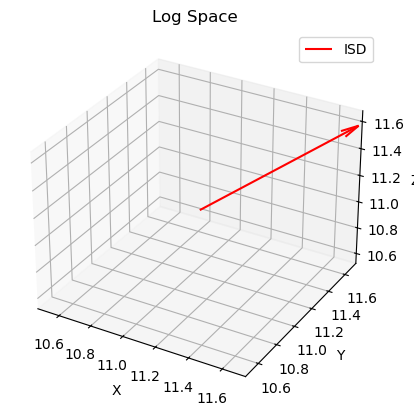

In [95]:
def plot_isd_vector_3D(mean_isd:np.array) -> None:
    """  
    Displays the mean ISD vector
    """
    # Set up 3D fig
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the ISD vector - This is through the origin, idk for sure about this
    ax.quiver(anchor_point, anchor_point, anchor_point, mean_isd[0], mean_isd[1], mean_isd[2], color='r', arrow_length_ratio=0.1, label="ISD")

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Log Space")

    # Add a legend
    ax.legend();

plot_isd_vector_3D(isd)

### Project Log RGB onto ISD  
$$projection = \vec{ISD} \cdot IMG_{log}$$  

This produces a scalar value for each pixel representing how much of the pixel intensity is along the ISD

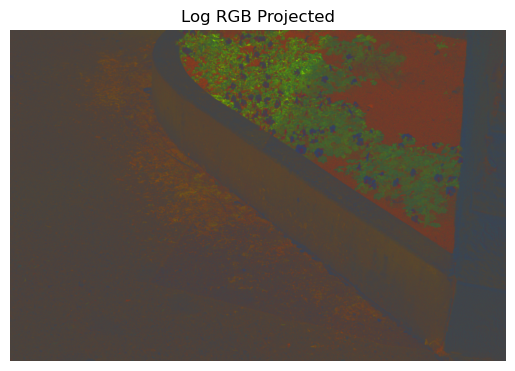

In [96]:
def project_to_plane(log_rgb: np.array, mean_isd: np.array, anchor_point: np.array) -> np.array:
    """
    Projects the log RGB values onto a plane defined by a normal vector,
    with the plane anchored at the given anchor point.

    Parameters:
    -----------
    log_rgb : np.array
        Log-transformed RGB values with shape (H, W, 3).
    mean_isd : np.array
        The normal vector of the plane.
    anchor_point : np.array
        The point where the plane is anchored in log space.

    Returns:
    --------
    projected_rgb : np.array
        Log RGB values projected onto the plane.
    """
    # Shift the log RGB values relative to the anchor point
    shifted_log_rgb = log_rgb - anchor_point

    # Normalize the isd vector
    norm_isd = mean_isd / np.linalg.norm(mean_isd)

    # Perform the projection for each pixel
    #projection = np.einsum('ijk,k->ij', shifted_log_rgb, mean_isd)[:, :, np.newaxis] * mean_isd

    # Computes a dot product along the last dimension of the RGB pixel data with the ISD vector
    # where, i: Height dimension, j: Width dimension, k: RGB channels (3 channels)
    # sum over the shared k dimension: RGB and ISD
    # contracts the k dimension, resulting array will have shape (H, W), indicated by ij in the output.
    dot_product = np.einsum('ijk,k->ij', shifted_log_rgb, norm_isd)

    # Reshape the dot product to (H, W, 1) for broadcasting
    dot_product_reshaped = dot_product[:, :, np.newaxis]

    # Multiply with the ISD vector to get the projected RGB values
    projection = dot_product_reshaped * norm_isd

    # Subtract the projection from the shifted values to get plane-projected values
    projected_rgb = shifted_log_rgb - projection

    # Shift the values back by adding the anchor point
    projected_rgb += anchor_point

    return projected_rgb

projected_log_rgb = project_to_plane(log_rgb, isd, np.full(3, 10.8))
projected_rgb = log_to_linear(projected_log_rgb)
display_image(projected_rgb, "Log RGB Projected")



### Visualizations of Log Space

In [97]:
def plot_log_space(img: np.array, mean_isd: np.array, anchor_point: float = 10.8, 
                   plot_plane=True, plot_pixels=True, plot_projection=True) -> None:
    """
    Displays the RGB pixel values of an image in log space within a 3D plot.

    Parameters:
    -----------
    img : np.array
        Input RGB image as a 3D array (H, W, 3).
    mean_isd : np.array
        ISD vector (illumination invariant direction) as a 1D array of size 3.
    anchor_point : float, optional (default=10.8)
        Anchor point for centering the plane in log space.
    plot_plane : bool, optional (default=True)
        Whether to plot the plane orthogonal to the ISD vector.
    plot_pixels : bool, optional (default=True)
        Whether to plot the pixel values in 3D space.
    plot_projection : bool, optional (default=True)
        Whether to plot the projection of pixel values onto the plane.

    Returns:
    --------
    None
    """
    # Convert the image to log space
    log_img = convert_img_to_log_space(img)

    # Set up 3D figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the ISD vector starting at the anchor point
    ax.quiver(anchor_point, anchor_point, anchor_point, 
              mean_isd[0], mean_isd[1], mean_isd[2], 
              color='r', arrow_length_ratio=0.3, label="ISD Vector")

    # Plot the plane orthogonal to the ISD vector, anchored at the anchor point
    if plot_plane:
        # Create a mesh grid around the plane center
        xx, yy = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
        # Ddjust origin to anchor point
        xx += anchor_point
        yy += anchor_point

        # Calculate the corresponding z values using the plane equation
        # (nx * (x - x0) + ny * (y - y0) + nz * (z - z0) = 0)
        # Rearranged: z = z0 - (nx * (x - x0) + ny * (y - y0)) / nz
        nomr_isd = mean_isd / np.linalg.norm(mean_isd)  # Normalize the isd vector
        zz = anchor_point - (nomr_isd[0] * (xx - anchor_point) + nomr_isd[1] * (yy - anchor_point)) / nomr_isd[2]

        # Plot the plane
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='cyan', label="Plane Orthogonal to ISD")

    img_8bit = convert_16bit_to_8bit(img_16bit)
    colors = img_8bit.reshape(-1, 3) / 255.0
    # Plot each pixel as a point in 3D space
    if plot_pixels:
        x, y, z = log_img[:, :, 0], log_img[:, :, 1], log_img[:, :, 2]
        ax.scatter(x, y, z, color=colors, marker='o', s=1, label="Pixel Values")

    # Compute and plot the projection onto the plane
    if plot_projection:

        # Project pixels onto the plane orthogonal to the ISD vector
        projected_img = project_to_plane(log_rgb, isd, np.full(3, anchor_point))

        # Extract the projected coordinates
        x_proj, y_proj, z_proj = projected_img[:, :, 0], projected_img[:, :, 1], projected_img[:, :, 2]

        # Plot the projected points
        ax.scatter(x_proj, y_proj, z_proj, color=colors, alpha=0.1, s=1, label="Projected Points")

    # Step 7: Set axis labels and title
    ax.set_xlabel('Log R')
    ax.set_ylabel('Log G')
    ax.set_zlabel('Log B')
    ax.set_title("Log RGB Space Visualization")
    ax.legend()

    # Show the plot
    plt.show()


Plot the plane orthogonal to the ISD - this the the new chromaticity space.

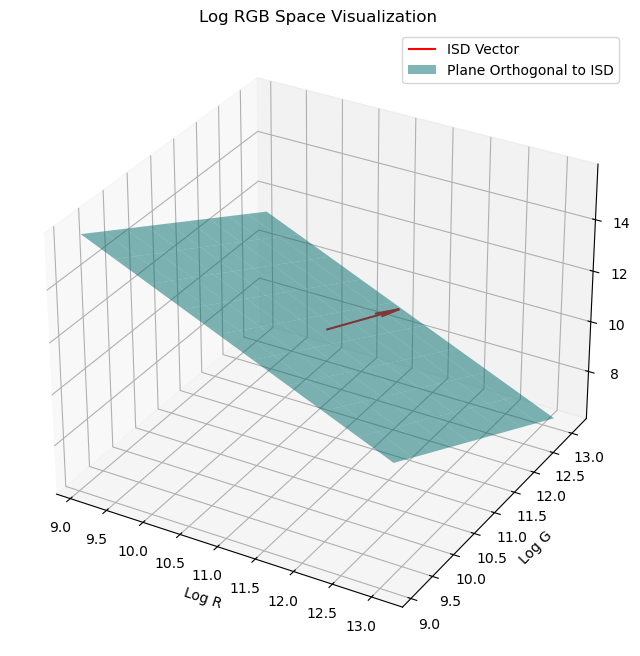

In [98]:
plot_log_space(img_16bit, isd, anchor_point, plot_plane=True, plot_pixels=False, plot_projection=False)

THe next image shows the pixel values for the log transformed RGB image.

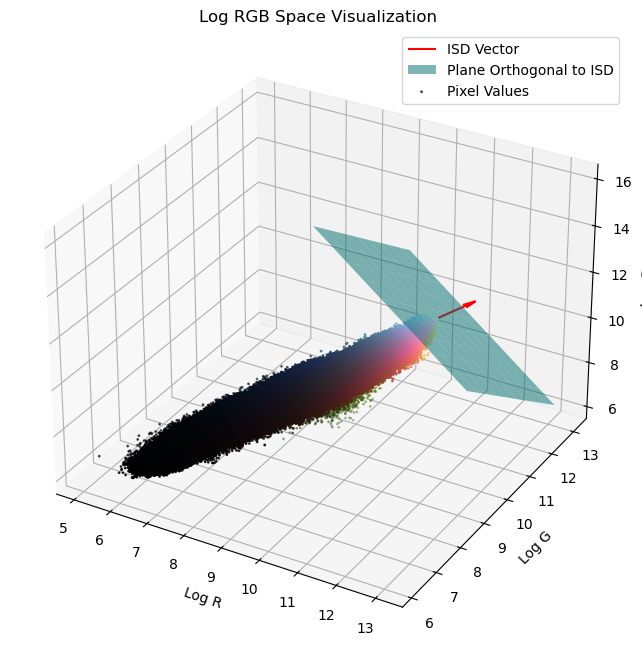

In [99]:
plot_log_space(img_16bit, isd, anchor_point, plot_plane=True, plot_pixels=True, plot_projection=False)

The last image shows the project of those pixels onto the log space chromaticity plane.

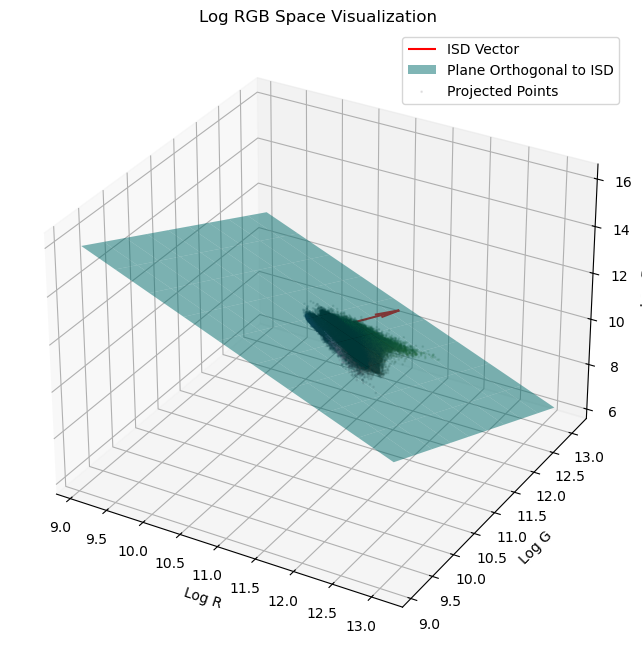

In [100]:
plot_log_space(img_16bit, isd, anchor_point, plot_plane=True, plot_pixels=False, plot_projection=True)

### Inspect Log Space Chromaticity Image

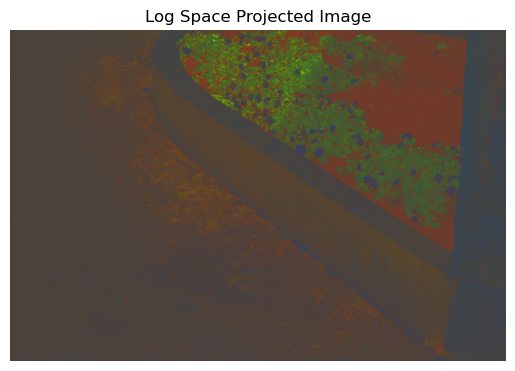

In [101]:
projected_rgb = log_to_linear(projected_log_rgb)
display_image(projected_rgb, "Log Space Projected Image")

___


## Show Results

Text(0.5, 1.0, 'Log Space Chromaticity')

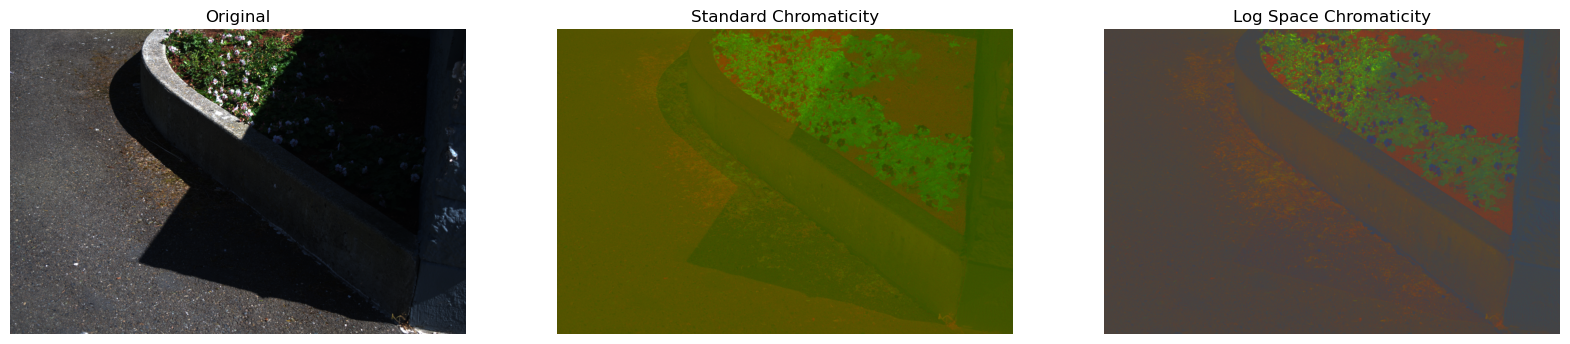

In [104]:
fig, axes = plt.subplots(1,3, figsize = (20, 20))
ax = axes.ravel()
img_8bit = convert_16bit_to_8bit(img_16bit)
ax[0].imshow(img_8bit)
ax[0].axis("off")
ax[0].set_title("Original")

ax[1].imshow(chromaticity_image)
ax[1].axis("off")
ax[1].set_title("Standard Chromaticity")

projected_rgb_8bit = convert_16bit_to_8bit(projected_rgb)
ax[2].imshow(projected_rgb_8bit)
ax[2].axis("off")
ax[2].set_title("Log Space Chromaticity")

In [103]:
import os
from nbconvert import HTMLExporter
import nbformat

# Load the notebook
with open('mike_scratch2.ipynb') as f:
    notebook = nbformat.read(f, as_version=4)

# Convert the notebook to HTML
html_exporter = HTMLExporter()
html_data, _ = html_exporter.from_notebook_node(notebook)

# Path to the directory you want to create
dir_path = "htmls/"

# Check if the directory exists and create it if it doesn't
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    print(f"Directory '{dir_path}' created.")

# Write the output to an HTML file
with open(dir_path + 'mike_scratch2.html', 'w') as f:
    f.write(html_data)